#### Description
This code uses distance to the nearest dam to calculate the targeting ratio between CPIS and Irrigated land. 

$$
\text{Targeting Ratio}_{(r = \text{distance range})} = \frac{\# \text{ of CPIS in } r}{\sum^{{countries}} ((\# \text{ of CPIS in country }) \times (\text{\% Irrigated Area in country in } r))}
$$


### Import libraries and set up project paths
Import all required libraries and set up the project root for module imports. This ensures that utility functions and spatial helpers are available throughout the notebook.

In [1]:
# Import required libraries
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from tqdm import tqdm
from scipy.spatial import cKDTree
import scipy.stats as stats
import numpy as np
import geopandas as gpd
import pandas as pd
import sys
import os

# Add the project root to sys.path so we can import from Code.utils everywhere
project_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

from Code.utils.utility import load_config, resolve_path, ssa_iso, africa_iso_countries, africa_iso_countries_filtered
from Code.utils.spatial_utility import load_and_reproject, optimized_clip

# Load configuration
config = load_config()

### Generate distance ranges
Create intervals for distance to the nearest dam. These ranges will be used to classify CPIS and irrigated land pixels for targeting ratio calculations.

In [2]:
# Generate 10 intervals between 0 and 100,000
interval_edges = np.linspace(0, 100000, num=11)

# Create the distance ranges as tuples
distance_ranges = [(interval_edges[i], interval_edges[i+1]) for i in range(len(interval_edges)-1)]

print(distance_ranges)

[(0.0, 10000.0), (10000.0, 20000.0), (20000.0, 30000.0), (30000.0, 40000.0), (40000.0, 50000.0), (50000.0, 60000.0), (60000.0, 70000.0), (70000.0, 80000.0), (80000.0, 90000.0), (90000.0, 100000.0)]


### Load and reproject spatial data
Use the utility functions to load and reproject dam, AEI, and CPIS shapefiles for each aridity layer. This ensures all data is in a common CRS for spatial analysis. 

In [ ]:
                                                                                                                                                                                                                         
# Load and reproject dam, AEI, and CPIS data using utility functions
layers = ['All', 'Semi_Arid', 'Arid', 'Hyper_Arid']

# Use load_and_reproject from spatial_utility for each file
layer_dam_gdfs = {layer: load_and_reproject(config[f"Africa_Dam_{layer}_shp_path"]) for layer in layers}
layer_AEI_gdfs = {layer: load_and_reproject(config[f"AEI_2015_{layer}_shp_path"]) for layer in layers}
layer_cpis_gdfs = {layer: load_and_reproject(config[f"Combined_CPIS_{layer}_shp_path"]) for layer in layers}

# Preview loaded data
for layer in layers:
    print(f"{layer} Dams:", layer_dam_gdfs[layer].head())
    print(f"{layer} AEI:", layer_AEI_gdfs[layer].head())
    print(f"{layer} CPIS:", layer_cpis_gdfs[layer].head())

# Print columns of each loaded GeoDataFrame to check for country code column name mismatches
# for layer in layers:
#     print(f"Layer: {layer}")
#     print("  Dam columns:", list(layer_dam_gdfs[layer].columns))
#     print("  AEI columns:", list(layer_AEI_gdfs[layer].columns))
#     print("  CPIS columns:", list(layer_cpis_gdfs[layer].columns))
#     print("-" * 40)



        Country  ISO     Sec_cntry        Name AltDamName  \
0      Zimbabwe  ZWE          None       Condo      Kondo   
1    Mozambique  MOZ  South Africa   Massingir       None   
2  South Africa  ZAF          None       Gants       None   
3  Burkina Faso  BFA          None        Lera        Nou   
4  South Africa  ZAF          None  Stompdrift       None   

                  Purpose    Admin_unit    Near_city      River  \
0  Hydropower, Irrigation          None  Chisumbanje       Save   
1  Hydropower; Irrigation          Gaza      Chokw??  Elefantes   
2              Irrigation  Western Cape   Touwsriver      Kraga   
3              Irrigation        Leraba         Lera      Comoe   
4              Irrigation  Western Cape      De Rust   Olifants   

           Main_basin  ... Gov_guaran  \
0                None  ...       None   
1             Limpopo  ...       None   
2  Indian Ocean Coast  ...       None   
3          West Coast  ...       None   
4  Indian Ocean Coast  ..

    raster_val  ISO                                           geometry
0   388.435089  TUN  POLYGON ((1038981.914 4462363.503, 1029705.290...
1   207.121201  TUN  POLYGON ((1057535.163 4474011.088, 1057535.163...
2   721.080872  TUN  POLYGON ((1066811.787 4474011.088, 1066811.787...
3   962.729492  TUN  POLYGON ((1076088.411 4474011.088, 1076088.411...
4  2777.154541  TUN  POLYGON ((1103918.284 4474011.088, 1113194.908...
    raster_val  ISO                                           geometry
0   388.435089  TUN  POLYGON ((1038981.914 4462363.503, 1029705.290...
1   207.121201  TUN  POLYGON ((1057535.163 4474011.088, 1057535.163...
2   721.080872  TUN  POLYGON ((1066811.787 4474011.088, 1066811.787...
3   962.729492  TUN  POLYGON ((1076088.411 4474011.088, 1076088.411...
4  2777.154541  TUN  POLYGON ((1103918.284 4474011.088, 1113194.908...
    raster_val  ISO                                           geometry
0   388.435089  TUN  POLYGON ((1038981.914 4462363.503, 1029705.290...
1   20

Sort CPIS by distance to nearest dam

### Calculate distance from each CPIS to the nearest dam
Use the `calculate_nearest_distances` function from the spatial utility module to compute the distance from each CPIS point to the nearest dam for each aridity layer.

In [ ]:

# Calculate nearest dam for each CPIS
def calculate_distances(src_gdf, target_gdf):
    src_centroids = np.array(list(src_gdf.geometry.centroid.apply(lambda geom: (geom.x, geom.y))))
    target_points = np.array(list(target_gdf.geometry.apply(lambda geom: (geom.x, geom.y))))
    
    if len(target_points) == 0:
        return np.array([])  # Return empty array if no points
    
    tree = cKDTree(target_points)
    dists, _ = tree.query(src_centroids, k=1)
    
    return dists

# Calculate the nearest dam for each CPIS
nearest_dam_distances = {}

for layer in layers:
    gdf_cpis = layer_cpis_gdfs[layer]
    gdf_dams = layer_dam_gdfs[layer]
    distances = calculate_distances(gdf_cpis, gdf_dams)
    nearest_dam_distances[layer] = distances


# Classify CPIS into distance ranges
def classify_cpis_by_distance_ranges(distances, distance_ranges):
    classifications = {}
    for (lower_bound, upper_bound) in distance_ranges:
        classifications[f'{lower_bound}-{upper_bound}'] = np.where(
            (distances >= lower_bound) & (distances < upper_bound), 1, 0)
    return classifications

cpis_classifications = {}

for layer in layers:
    distances = nearest_dam_distances[layer]
    cpis_classifications[layer] = classify_cpis_by_distance_ranges(distances, distance_ranges)
    print(cpis_classifications[layer])
                                                                                                                                                                                                                         
# Load and reproject dam, AEI, and CPIS data using utility functions
layers = ['All', 'Semi_Arid', 'Arid', 'Hyper_Arid']

# Use load_and_reproject from spatial_utility for each file
layer_dam_gdfs = {layer: load_and_reproject(config[f"Africa_Dam_{layer}_shp_path"]) for layer in layers}
layer_AEI_gdfs = {layer: load_and_reproject(config[f"AEI_2015_{layer}_shp_path"]) for layer in layers}
layer_cpis_gdfs = {layer: load_and_reproject(config[f"Combined_CPIS_{layer}_shp_path"]) for layer in layers}

# Preview loaded data
for layer in layers:
    print(f"{layer} Dams:", layer_dam_gdfs[layer].head())
    print(f"{layer} AEI:", layer_AEI_gdfs[layer].head())
    print(f"{layer} CPIS:", layer_cpis_gdfs[layer].head())

# Print columns of each loaded GeoDataFrame to check for country code column name mismatches
for layer in layers:
    print(f"Layer: {layer}")
    print("  Dam columns:", list(layer_dam_gdfs[layer].columns))
    print("  AEI columns:", list(layer_AEI_gdfs[layer].columns))
    print("  CPIS columns:", list(layer_cpis_gdfs[layer].columns))
    print("-" * 40)



{'0.0-10000.0': array([0, 0, 0, ..., 0, 0, 0]), '10000.0-20000.0': array([0, 0, 0, ..., 0, 0, 0]), '20000.0-30000.0': array([1, 1, 1, ..., 0, 0, 0]), '30000.0-40000.0': array([0, 0, 0, ..., 0, 0, 0]), '40000.0-50000.0': array([0, 0, 0, ..., 0, 0, 0]), '50000.0-60000.0': array([0, 0, 0, ..., 0, 0, 0]), '60000.0-70000.0': array([0, 0, 0, ..., 0, 0, 0]), '70000.0-80000.0': array([0, 0, 0, ..., 0, 0, 0]), '80000.0-90000.0': array([0, 0, 0, ..., 0, 0, 0]), '90000.0-100000.0': array([0, 0, 0, ..., 0, 0, 0])}
{'0.0-10000.0': array([0, 0, 0, ..., 0, 0, 0]), '10000.0-20000.0': array([0, 0, 0, ..., 0, 0, 0]), '20000.0-30000.0': array([1, 1, 1, ..., 0, 0, 0]), '30000.0-40000.0': array([0, 0, 0, ..., 1, 1, 1]), '40000.0-50000.0': array([0, 0, 0, ..., 0, 0, 0]), '50000.0-60000.0': array([0, 0, 0, ..., 0, 0, 0]), '60000.0-70000.0': array([0, 0, 0, ..., 0, 0, 0]), '70000.0-80000.0': array([0, 0, 0, ..., 0, 0, 0]), '80000.0-90000.0': array([0, 0, 0, ..., 0, 0, 0]), '90000.0-100000.0': array([0, 0, 0, 

### Calculate proportion of irrigated land within each distance range per country
For each country and aridity layer, calculate the proportion of irrigated land pixels that fall within each distance range from a dam. This is used as the denominator in the targeting ratio.

In [7]:
def calculate_proportion_irrigated_pixels(layer_AEI_gdfs, layer_dam_gdfs, distance_ranges, layers):
    proportion_irrigated_pixels = {}

    for layer in layers:
        gdf_AEI = layer_AEI_gdfs[layer]
        gdf_dams = layer_dam_gdfs[layer]

        proportions_by_country_and_range = {}
        #print(gdf_AEI.columns)
        #print(gdf_dams.columns)

        for iso3 in gdf_AEI['ISO'].unique():
            country_group = gdf_AEI[gdf_AEI['ISO'] == iso3]
            dams_in_country = gdf_dams[gdf_dams['ISO'] == iso3]

            distances = calculate_distances(country_group, dams_in_country)

            proportions_by_range = {}
            total_pixels = len(country_group)

            for (lower_bound, upper_bound) in distance_ranges:
                within_range = np.sum((distances >= lower_bound) & (distances < upper_bound))
    
                if total_pixels == 0:
                    proportions_by_range[f'{lower_bound}-{upper_bound}'] = 0  # or skip this range
                    #print(f"Skipping range {lower_bound}-{upper_bound} due to total_pixels being 0")
                else:
                    proportions_by_range[f'{lower_bound}-{upper_bound}'] = within_range / total_pixels
                    # Debug print statement
                    #print(f"Country: {iso3}, Range {lower_bound}-{upper_bound}: {within_range} pixels within range, Total pixels: {total_pixels}")
            
            proportions_by_country_and_range[iso3] = proportions_by_range
            #print(iso3)
            #print(proportions_by_country_and_range[iso3])

        proportion_irrigated_pixels[layer] = proportions_by_country_and_range

    return proportion_irrigated_pixels

proportion_irrigated_pixels = calculate_proportion_irrigated_pixels(layer_AEI_gdfs, layer_dam_gdfs, distance_ranges, layers)
print(proportion_irrigated_pixels)

{'All': {'TUN': {'0.0-10000.0': 0.0, '10000.0-20000.0': 0.0, '20000.0-30000.0': 0.0, '30000.0-40000.0': 0.0, '40000.0-50000.0': 0.0, '50000.0-60000.0': 0.0, '60000.0-70000.0': 0.0, '70000.0-80000.0': 0.0, '80000.0-90000.0': 0.0, '90000.0-100000.0': 0.0}, 'DZA': {'0.0-10000.0': 0.0, '10000.0-20000.0': 0.0, '20000.0-30000.0': 0.0, '30000.0-40000.0': 0.0, '40000.0-50000.0': 0.0, '50000.0-60000.0': 0.0, '60000.0-70000.0': 0.0, '70000.0-80000.0': 0.0, '80000.0-90000.0': 0.0, '90000.0-100000.0': 0.0}, 'MAR': {'0.0-10000.0': 0.0, '10000.0-20000.0': 0.0, '20000.0-30000.0': 0.0, '30000.0-40000.0': 0.0, '40000.0-50000.0': 0.0, '50000.0-60000.0': 0.0, '60000.0-70000.0': 0.0, '70000.0-80000.0': 0.0, '80000.0-90000.0': 0.0, '90000.0-100000.0': 0.0}, 'LBY': {'0.0-10000.0': 0.0, '10000.0-20000.0': 0.0, '20000.0-30000.0': 0.0, '30000.0-40000.0': 0.0, '40000.0-50000.0': 0.0, '50000.0-60000.0': 0.0, '60000.0-70000.0': 0.0, '70000.0-80000.0': 0.0, '80000.0-90000.0': 0.0, '90000.0-100000.0': 0.0}, 'EGY': 

### Calculate targeting ratios and confidence intervals
Compute the targeting ratio for each distance range and aridity layer, and estimate 95% confidence intervals using bootstrapping. This quantifies the relationship between CPIS and irrigated land near dams.

Processing layer: All
Processing range: 0.0-10000.0
Numerator: 1252
Denominator: 1405.4487203612323
Processing range: 10000.0-20000.0
Numerator: 2355
Denominator: 2906.2222571694097
Processing range: 20000.0-30000.0
Numerator: 3131
Denominator: 3257.5827686802772
Processing range: 30000.0-40000.0
Numerator: 3336


Denominator: 3134.076361701972
Processing range: 40000.0-50000.0
Numerator: 3557
Denominator: 3223.2668146098954
Processing range: 50000.0-60000.0
Numerator: 2757
Denominator: 2727.759926233148
Processing range: 60000.0-70000.0
Numerator: 2665
Denominator: 2321.538103932553
Processing range: 70000.0-80000.0
Numerator: 2388
Denominator: 1906.9087182825772
Processing range: 80000.0-90000.0
Numerator: 1648
Denominator: 1529.9489156221455
Processing range: 90000.0-100000.0
Numerator: 900
Denominator: 1038.5898449537888
Targeting Ratios for All layer:
0.0-10000.0: 0.8908 (95% CI: 0.8226, 0.9634)
10000.0-20000.0: 0.8103 (95% CI: 0.7664, 0.8551)
20000.0-30000.0: 0.9611 (95% CI: 0.9130, 1.0086)
30000.0-40000.0: 1.0644 (95% CI: 1.0149, 1.1193)
40000.0-50000.0: 1.1035 (95% CI: 1.0528, 1.1534)
50000.0-60000.0: 1.0107 (95% CI: 0.9613, 1.0618)
60000.0-70000.0: 1.1479 (95% CI: 1.0850, 1.2150)
70000.0-80000.0: 1.2523 (95% CI: 1.1849, 1.3219)
80000.0-90000.0: 1.0772 (95% CI: 1.0039, 1.1542)
90000.0-10

/tmp/ipykernel_967591/1926538955.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f'{int(float(label.get_text().split("-")[0]))/1000:.0f}-{int(float(label.get_text().split("-")[1])/1000)} km'


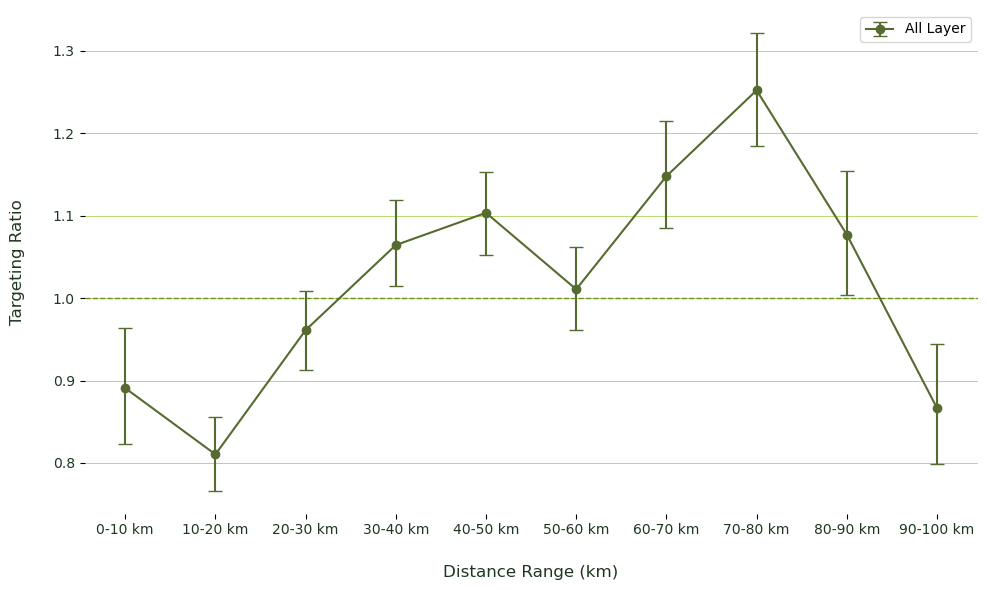

/tmp/ipykernel_967591/1926538955.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f'{int(float(label.get_text().split("-")[0]))/1000:.0f}-{int(float(label.get_text().split("-")[1])/1000)} km'


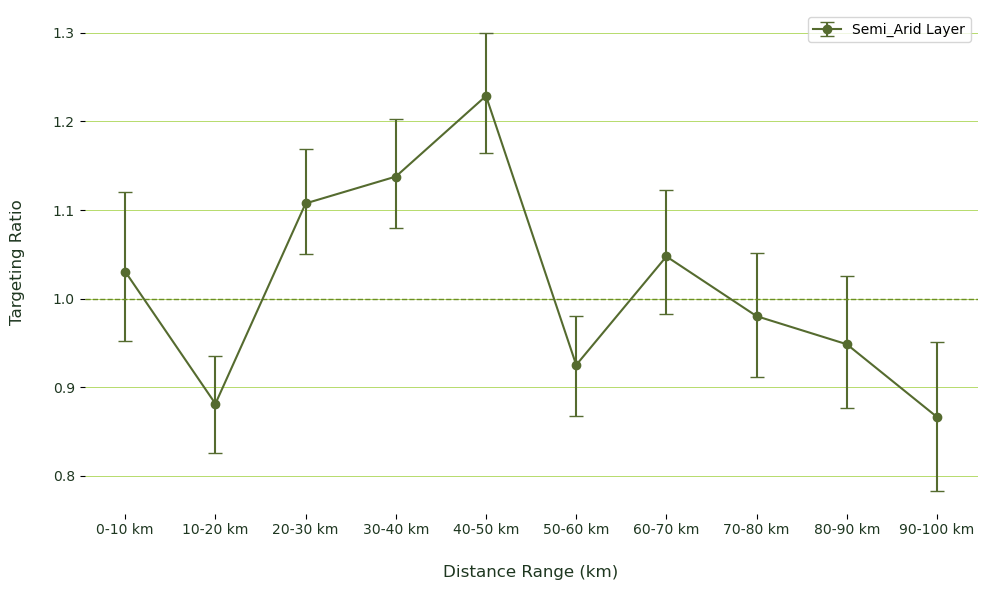

/tmp/ipykernel_967591/1926538955.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f'{int(float(label.get_text().split("-")[0]))/1000:.0f}-{int(float(label.get_text().split("-")[1])/1000)} km'


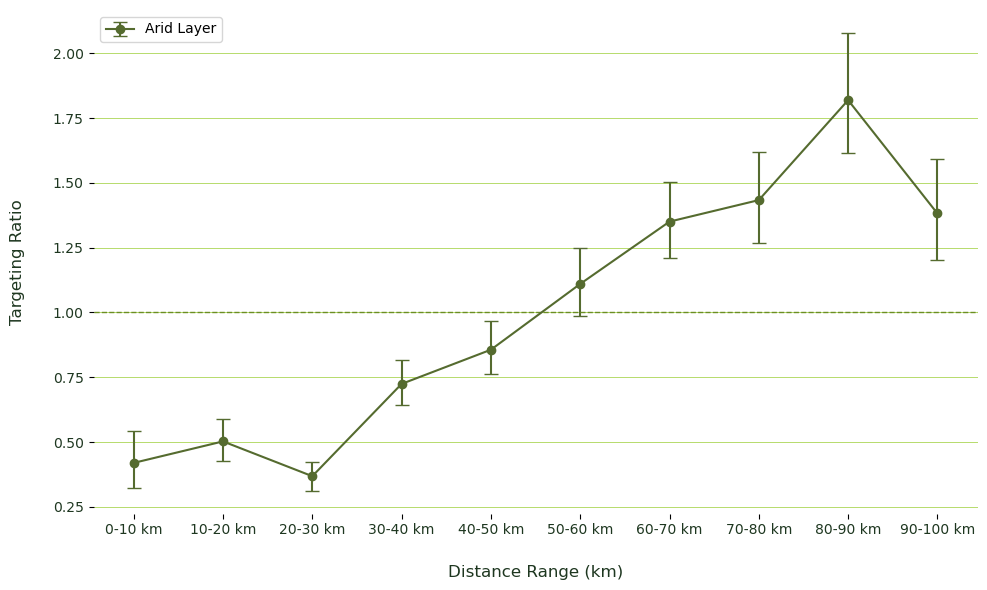

/tmp/ipykernel_967591/1926538955.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f'{int(float(label.get_text().split("-")[0]))/1000:.0f}-{int(float(label.get_text().split("-")[1])/1000)} km'


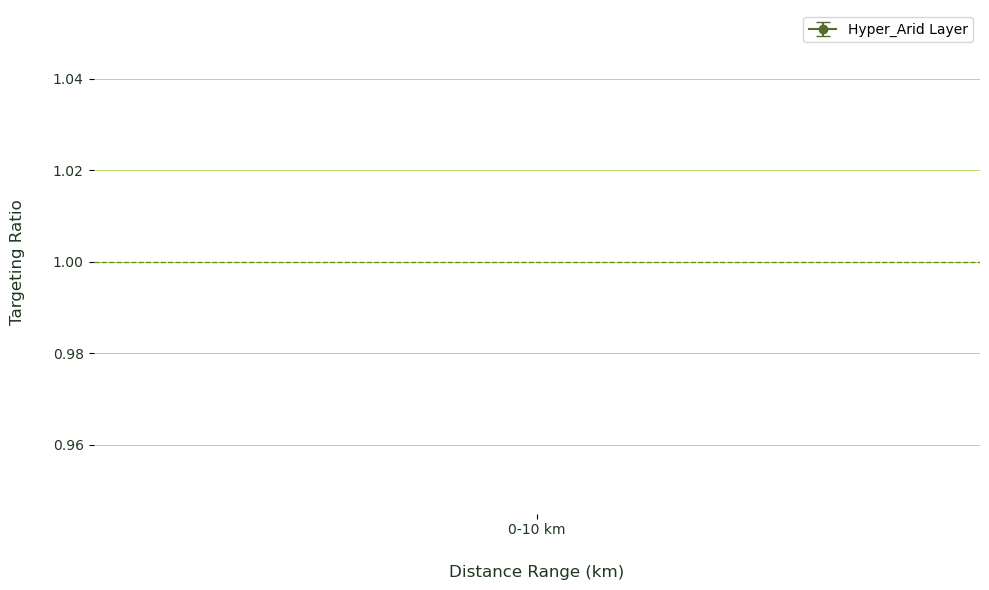

In [12]:
from Code.utils.spatial_utility import calculate_nearest_distances, classify_by_distance_ranges, bootstrap_targeting_ratio

def calculate_targeting_ratios_with_bootstrap(cpis_classifications, proportion_irrigated_pixels, layers, num_bootstrap=1000):
    targeting_ratios_by_layer = {}
    confidence_intervals_by_layer = {}
    numerators_by_layer = {}
    denominators_by_layer = {}
    for layer in layers:
        print(f"Processing layer: {layer}")
        classifications = cpis_classifications.get(layer, {})
        proportions = proportion_irrigated_pixels.get(layer, {})
        targeting_ratios = {}
        confidence_intervals = {}
        numerators = {}
        denominators = {}
        for range_key in classifications.keys():
            print(f"Processing range: {range_key}")
            numerator = np.sum(classifications[range_key])
            print(f"Numerator: {numerator}")
            denominator = 0
            for iso3 in proportions.keys():
                if range_key in proportions[iso3]:
                    cpis_in_country = np.sum(layer_cpis_gdfs[layer]['Country Co'] == iso3)
                    percentage_in_range = proportions[iso3][range_key]
                    denominator += cpis_in_country * percentage_in_range
            print(f"Denominator: {denominator}")
            targeting_ratio = numerator / denominator if denominator != 0 else np.nan
            # Bootstrap CI calculation using utility function
            if denominator != 0:
                ci_lower, ci_upper = bootstrap_targeting_ratio(numerator, denominator, num_bootstrap=num_bootstrap)
            else:
                ci_lower, ci_upper = np.nan, np.nan
            targeting_ratios[range_key] = targeting_ratio
            confidence_intervals[range_key] = (ci_lower, ci_upper)
            numerators[range_key] = numerator
            denominators[range_key] = denominator
        targeting_ratios_by_layer[layer] = targeting_ratios
        confidence_intervals_by_layer[layer] = confidence_intervals
        numerators_by_layer[layer] = numerators
        denominators_by_layer[layer] = denominators
        print(f"Targeting Ratios for {layer} layer:")
        for range_key, ratio in targeting_ratios.items():
            ci = confidence_intervals[range_key]
            print(f"{range_key}: {ratio:.4f} (95% CI: {ci[0]:.4f}, {ci[1]:.4f})")
    return targeting_ratios_by_layer, confidence_intervals_by_layer, numerators_by_layer, denominators_by_layer

def plot_targeting_ratios_with_ci(targeting_ratios_by_layer, confidence_intervals_by_layer):
    fig_num = 0
    for layer, ratios in targeting_ratios_by_layer.items():
        ranges = list(ratios.keys())
        ratio_values = np.array(list(ratios.values()))
        ci_lower = np.array([confidence_intervals_by_layer[layer][range_key][0] for range_key in ranges])
        ci_upper = np.array([confidence_intervals_by_layer[layer][range_key][1] for range_key in ranges])
        error = np.array([ratio_values - ci_lower, ci_upper - ratio_values])
        plt.figure(figsize=(10, 6))
        ax = plt.gca()
        for spine in ax.spines.values():
            spine.set_visible(False)
        ax.set_facecolor('white')
        plt.gcf().set_facecolor('white')
        plt.errorbar(ranges, ratio_values, yerr=error, fmt='-o', capsize=5, color='darkolivegreen', label=f'{layer} Layer')
        plt.axhline(y=1, color='olivedrab', linestyle='--', linewidth=1)
        ax.grid(True, axis='y', linestyle='-', linewidth=0.5, color='yellowgreen')
        ax.grid(False, axis='x')
        ax.set_xticklabels([f'{int(float(label.get_text().split("-")[0]))/1000:.0f}-{int(float(label.get_text().split("-")[1])/1000)} km' 
                            if "-" in label.get_text() else label.get_text() 
                            for label in ax.get_xticklabels()])
        plt.xlabel('Distance Range (km)', fontsize=12, labelpad=20, color='#1E3720')
        plt.ylabel('Targeting Ratio', fontsize=12, labelpad=20, color='#1E3720')
        plt.xticks(color='#1E3720')
        plt.yticks(color='#1E3720')
        plt.legend()
        plt.tight_layout()
        plt.savefig(resolve_path(config[f'3_Figure{fig_num}']))
        fig_num += 1
        plt.show()

# Call the function with your data
targeting_ratios_by_layer, confidence_intervals_by_layer, numerators_by_layer, denominators_by_layer = calculate_targeting_ratios_with_bootstrap(cpis_classifications, proportion_irrigated_pixels, layers)

# Plot the results
plot_targeting_ratios_with_ci(targeting_ratios_by_layer, confidence_intervals_by_layer)